# 🎯 Estratégia de Máxima PRECISÃO para Data Linkage
## Objetivo: Minimizar Falsos Positivos - Pares de Alta Confiança

Este notebook implementa uma estratégia conservadora para **maximizar a precisão** do linkage, priorizando a identificação de pares com alta confiança e minimizando a necessidade de revisão manual.

### Técnicas Implementadas:
1. **Stacking com Meta-Learner Conservador** - Combina modelos com regra final rigorosa
2. **Threshold Otimizado para Precisão** - Ponto de corte alto
3. **Regras de Negócio** - Filtros adicionais baseados em conhecimento do domínio
4. **Isolation Forest** - Detecção de anomalias para filtrar outliers
5. **Calibração de Probabilidades** - Probabilidades mais confiáveis
6. **Consensus Voting** - Apenas classifica como par se múltiplos modelos concordam
7. **Feature Selection Rigorosa** - Apenas features mais discriminativas

In [1]:
# Instalação de dependências
!pip install -q pandas numpy scikit-learn xgboost lightgbm imbalanced-learn matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    StackingClassifier, IsolationForest, ExtraTreesClassifier
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, f1_score, precision_score, recall_score,
    average_precision_score
)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Configurações
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

print("✅ Bibliotecas carregadas com sucesso!")

✅ Bibliotecas carregadas com sucesso!


## 1. Carregamento e Preparação dos Dados

In [3]:
# Carregar dados
from pathlib import Path

def find_data_path(filename: str = 'COMPARADORSEMIDENT.csv') -> Path:
    for base in (Path.cwd(), *Path.cwd().parents):
        candidate = base / 'data' / filename
        if candidate.exists():
            return candidate
    raise FileNotFoundError(
        f"Nao foi possivel localizar data/{filename}. CWD={Path.cwd()}"
    )

DATA_PATH = find_data_path()
df = pd.read_csv(DATA_PATH, sep=';', low_memory=False)
print(f"Lendo arquivo: {DATA_PATH.resolve()}")

# Limpar nomes das colunas
def clean_col(col):
    return col.split(',')[0] if ',' in col else col
df.columns = [clean_col(c) for c in df.columns]

# Converter colunas numéricas
for col in df.columns:
    if df[col].dtype == object:
        try:
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')
        except:
            pass

# Target
df['TARGET'] = (df['PAR'].isin([1, 2])).astype(int)

print(f"Dataset: {df.shape[0]:,} registros")
print(f"Pares verdadeiros: {df['TARGET'].sum()} ({df['TARGET'].mean()*100:.2f}%)")

Lendo arquivo: D:\git\phd-research\data\COMPARADORSEMIDENT.csv


Dataset: 61,696 registros
Pares verdadeiros: 247 (0.40%)


In [4]:
# Feature Engineering focado em PRECISÃO
# Usar apenas features mais discriminativas e criar combinações de alta confiança

SCORE_COLS = [
    'NOME prim frag igual', 'NOME ult frag igual', 'NOME qtd frag iguais',
    'NOME qtd frag raros', 'NOME qtd frag comuns', 'NOME qtd frag muito parec', 'NOME qtd frag abrev',
    'NOMEMAE prim frag igual', 'NOMEMAE ult frag igual', 'NOMEMAE qtd frag iguais',
    'NOMEMAE qtd frag raros', 'NOMEMAE qtd frag comuns', 'NOMEMAE qtd frag muito parec',
    'DTNASC dt iguais', 'DTNASC dt ap 1digi', 'DTNASC dt inv dia', 'DTNASC dt inv mes', 'DTNASC dt inv ano',
    'CODMUNRES uf igual', 'CODMUNRES local igual', 'CODMUNRES local prox',
    'ENDERECO via igual', 'ENDERECO via prox', 'ENDERECO numero igual',
    'ENDERECO compl prox', 'ENDERECO texto prox', 'ENDERECO tokens jacc',
    'nota final'
]

available_cols = [c for c in SCORE_COLS if c in df.columns]
X = df[available_cols].fillna(0).copy()

print(f"Features base: {len(available_cols)}")

# ============================================
# FEATURE ENGINEERING PARA PRECISÃO
# ============================================

# 1. Scores agregados com pesos conservadores
X['nome_total'] = (X['NOME prim frag igual'] * 0.3 + 
                   X['NOME ult frag igual'] * 0.3 + 
                   X['NOME qtd frag iguais'] * 0.4)

X['mae_total'] = (X['NOMEMAE prim frag igual'] * 0.25 + 
                  X['NOMEMAE ult frag igual'] * 0.25 + 
                  X['NOMEMAE qtd frag iguais'] * 0.5)

# 2. Flags de alta confiança (critérios rigorosos)
X['nome_perfeito'] = (X['NOME qtd frag iguais'] >= 0.95).astype(int)
X['nome_excelente'] = (X['NOME qtd frag iguais'] >= 0.85).astype(int)
X['dtnasc_exato'] = (X['DTNASC dt iguais'] == 1).astype(int)
X['dtnasc_quase'] = ((X['DTNASC dt iguais'] == 1) | (X['DTNASC dt ap 1digi'] == 1)).astype(int)
X['mae_forte'] = (X['NOMEMAE qtd frag iguais'] >= 0.6).astype(int)
X['local_exato'] = (X['CODMUNRES local igual'] == 1).astype(int)
X['endereco_match'] = (X['ENDERECO via igual'] == 1).astype(int)

# 3. Score de precisão (combinação de evidências fortes)
X['score_precisao'] = (
    X['nome_perfeito'] * 3.0 +
    X['dtnasc_exato'] * 3.0 +
    X['mae_forte'] * 2.0 +
    X['local_exato'] * 1.5 +
    X['endereco_match'] * 1.0
)

# 4. Contagem de critérios de alta confiança atendidos
X['criterios_fortes'] = (
    X['nome_perfeito'] + X['dtnasc_exato'] + X['mae_forte'] + 
    X['local_exato'] + X['endereco_match']
)

# 5. Mínimos (para garantir consistência)
X['min_nome_mae'] = X[['nome_total', 'mae_total']].min(axis=1)
X['min_nome_dtnasc'] = X[['NOME qtd frag iguais', 'DTNASC dt iguais']].min(axis=1)

# 6. Interações de alta confiança
X['nome_e_dtnasc'] = X['nome_perfeito'] * X['dtnasc_exato']
X['nome_e_mae'] = X['nome_perfeito'] * X['mae_forte']
X['dtnasc_e_local'] = X['dtnasc_exato'] * X['local_exato']
X['trifecta'] = X['nome_perfeito'] * X['dtnasc_exato'] * X['mae_forte']  # Tripla confirmação

# 7. Variáveis do contexto
X['obito_sinan'] = df['C_SITUENCE'].isin([3, 4]).astype(int)

# 8. Diferença de datas
df['R_DT_ANO'] = df['R_DTNASC'].astype(str).str[:4].astype(float)
df['C_DT_ANO'] = df['C_DTNASC'].astype(str).str[:4].astype(float)
X['diff_ano'] = np.abs(df['R_DT_ANO'] - df['C_DT_ANO']).fillna(99)
X['ano_consistente'] = (X['diff_ano'] <= 2).astype(int)  # Critério rigoroso: máx 2 anos

# 9. Nota final ao quadrado (amplifica diferenças)
X['nota_squared'] = X['nota final'] ** 2
X['nota_cubed'] = X['nota final'] ** 3

print(f"\nTotal de features após engineering: {X.shape[1]}")

Features base: 28

Total de features após engineering: 50


In [5]:
# Preparar dados
y = df['TARGET'].copy()

# Divisão estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Guardar índices
train_idx = X_train.index
test_idx = X_test.index

print(f"Treino: {len(X_train):,} ({y_train.sum()} pares)")
print(f"Teste: {len(X_test):,} ({y_test.sum()} pares)")

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Treino: 43,187 (173 pares)


Teste: 18,509 (74 pares)


## 2. Seleção de Features Rigorosa

In [6]:
# Selecionar apenas as features mais importantes
print("Selecionando features mais discriminativas...\n")

# Usar Random Forest para feature importance
rf_selector = RandomForestClassifier(
    n_estimators=200, max_depth=10, 
    class_weight='balanced', random_state=42, n_jobs=-1
)
rf_selector.fit(X_train, y_train)

# Importância das features
feature_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Features mais importantes:")
print(feature_imp.head(15).to_string(index=False))

# Selecionar top features
TOP_N_FEATURES = 25
selected_features = feature_imp.head(TOP_N_FEATURES)['feature'].tolist()

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"\nFeatures selecionadas: {len(selected_features)}")

Selecionando features mais discriminativas...



Top 15 Features mais importantes:
                     feature  importance
              score_precisao    0.111076
            criterios_fortes    0.103164
                  nome_total    0.084525
                  nota_cubed    0.080848
        NOME qtd frag iguais    0.079146
   NOME qtd frag muito parec    0.073853
                  nota final    0.072225
                nota_squared    0.070404
               nome_perfeito    0.052726
                dtnasc_quase    0.037290
              nome_excelente    0.034927
        NOME qtd frag comuns    0.022623
                    diff_ano    0.020837
     NOMEMAE qtd frag comuns    0.018923
NOMEMAE qtd frag muito parec    0.018719

Features selecionadas: 25


## 3. Modelos Otimizados para Precisão

In [7]:
# Função de avaliação
def evaluate_precision_model(model, X_tr, y_tr, X_te, y_te, model_name, threshold=0.5):
    model.fit(X_tr, y_tr)
    
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_te)[:, 1]
    else:
        y_proba = model.decision_function(X_te)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    
    y_pred = (y_proba >= threshold).astype(int)
    
    return {
        'name': model_name,
        'threshold': threshold,
        'precision': precision_score(y_te, y_pred, zero_division=0),
        'recall': recall_score(y_te, y_pred),
        'f1': f1_score(y_te, y_pred),
        'auc_roc': roc_auc_score(y_te, y_proba),
        'auc_pr': average_precision_score(y_te, y_proba),
        'n_positivos': y_pred.sum(),
        'y_proba': y_proba,
        'model': model
    }

In [8]:
# Aplicar SMOTE moderado (não extremo, para manter qualidade)
smote = SMOTE(sampling_strategy=0.3, random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

print(f"Após SMOTE: {len(y_train_smote):,} amostras ({y_train_smote.sum():,} pares)")

Após SMOTE: 55,918 amostras (12,904 pares)


In [9]:
# Treinar modelos com diferentes thresholds altos
results = []

print("Treinando modelos otimizados para precisão...\n")

# 1. XGBoost com regularização forte
xgb_precision = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,  # Raso para evitar overfitting
    learning_rate=0.05,
    reg_alpha=1.0,  # L1 regularization
    reg_lambda=2.0,  # L2 regularization
    scale_pos_weight=10,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

for th in [0.6, 0.7, 0.8, 0.9]:
    res = evaluate_precision_model(
        xgb_precision, X_train_smote.values, y_train_smote, 
        X_test_selected.values, y_test, f'XGBoost (th={th})', threshold=th
    )
    results.append(res)
    print(f"{res['name']}: Precision={res['precision']:.4f}, Recall={res['recall']:.4f}, N={res['n_positivos']}")

print()

Treinando modelos otimizados para precisão...



XGBoost (th=0.6): Precision=0.7604, Recall=0.9865, N=96


XGBoost (th=0.7): Precision=0.8111, Recall=0.9865, N=90


XGBoost (th=0.8): Precision=0.8588, Recall=0.9865, N=85


XGBoost (th=0.9): Precision=0.9012, Recall=0.9865, N=81



In [10]:
# 2. LightGBM com configuração conservadora
lgb_precision = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    num_leaves=15,  # Conservador
    min_child_samples=50,  # Evita overfitting
    reg_alpha=0.5,
    reg_lambda=1.0,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)

for th in [0.6, 0.7, 0.8, 0.9]:
    res = evaluate_precision_model(
        lgb_precision, X_train_smote.values, y_train_smote,
        X_test_selected.values, y_test, f'LightGBM (th={th})', threshold=th
    )
    results.append(res)
    print(f"{res['name']}: Precision={res['precision']:.4f}, Recall={res['recall']:.4f}, N={res['n_positivos']}")

print()

LightGBM (th=0.6): Precision=0.8659, Recall=0.9595, N=82


LightGBM (th=0.7): Precision=0.8987, Recall=0.9595, N=79


LightGBM (th=0.8): Precision=0.9091, Recall=0.9459, N=77


LightGBM (th=0.9): Precision=0.9200, Recall=0.9324, N=75



In [11]:
# 3. Random Forest com calibração de probabilidades
print("Treinando Random Forest com calibração...")

rf_base = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_calibrated = CalibratedClassifierCV(rf_base, method='isotonic', cv=5)

for th in [0.7, 0.8, 0.9]:
    res = evaluate_precision_model(
        rf_calibrated, X_train_smote.values, y_train_smote,
        X_test_selected.values, y_test, f'RF Calibrado (th={th})', threshold=th
    )
    results.append(res)
    print(f"{res['name']}: Precision={res['precision']:.4f}, Recall={res['recall']:.4f}, N={res['n_positivos']}")

print()

Treinando Random Forest com calibração...


RF Calibrado (th=0.7): Precision=0.8684, Recall=0.8919, N=76


RF Calibrado (th=0.8): Precision=0.8800, Recall=0.8919, N=75


RF Calibrado (th=0.9): Precision=0.9155, Recall=0.8784, N=71



## 4. Stacking com Meta-Learner Conservador

In [12]:
# Stacking: combina modelos com meta-learner que prioriza precisão
print("Construindo Stacking Classifier...\n")

base_estimators = [
    ('xgb', xgb.XGBClassifier(
        n_estimators=150, max_depth=4, learning_rate=0.05,
        random_state=42, use_label_encoder=False, eval_metric='logloss'
    )),
    ('lgb', lgb.LGBMClassifier(
        n_estimators=150, max_depth=4, learning_rate=0.05,
        random_state=42, verbose=-1
    )),
    ('rf', RandomForestClassifier(
        n_estimators=150, max_depth=6, class_weight='balanced',
        random_state=42, n_jobs=-1
    )),
    ('gb', GradientBoostingClassifier(
        n_estimators=100, max_depth=4, learning_rate=0.05,
        random_state=42
    ))
]

# Meta-learner: Logistic Regression com regularização forte
meta_learner = LogisticRegression(
    C=0.1,  # Regularização forte
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

stacking_precision = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_learner,
    cv=5,
    passthrough=True,  # Inclui features originais
    n_jobs=-1
)

stacking_precision.fit(X_train_smote.values, y_train_smote)
y_proba_stack = stacking_precision.predict_proba(X_test_selected.values)[:, 1]

print("Performance do Stacking com diferentes thresholds:")
for th in [0.5, 0.6, 0.7, 0.8, 0.9]:
    y_pred_stack = (y_proba_stack >= th).astype(int)
    prec = precision_score(y_test, y_pred_stack, zero_division=0)
    rec = recall_score(y_test, y_pred_stack)
    n_pos = y_pred_stack.sum()
    print(f"  Threshold {th}: Precision={prec:.4f}, Recall={rec:.4f}, N={n_pos}")
    
    if th == 0.8:  # Guardar resultado com threshold alto
        results.append({
            'name': f'Stacking (th={th})',
            'threshold': th,
            'precision': prec,
            'recall': rec,
            'f1': f1_score(y_test, y_pred_stack),
            'auc_roc': roc_auc_score(y_test, y_proba_stack),
            'auc_pr': average_precision_score(y_test, y_proba_stack),
            'n_positivos': n_pos,
            'y_proba': y_proba_stack,
            'model': stacking_precision
        })

Construindo Stacking Classifier...



Performance do Stacking com diferentes thresholds:
  Threshold 0.5: Precision=0.7912, Recall=0.9730, N=91
  Threshold 0.6: Precision=0.7912, Recall=0.9730, N=91
  Threshold 0.7: Precision=0.8000, Recall=0.9730, N=90
  Threshold 0.8: Precision=0.8090, Recall=0.9730, N=89
  Threshold 0.9: Precision=0.8353, Recall=0.9595, N=85


## 5. Consensus Voting (Unanimidade entre Modelos)

In [13]:
# Consensus: Só classifica como par se TODOS os modelos concordam
print("\nImplementando Consensus Voting...\n")

# Treinar modelos individuais
models_consensus = {
    'XGBoost': xgb.XGBClassifier(
        n_estimators=200, max_depth=5, random_state=42,
        use_label_encoder=False, eval_metric='logloss'
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=200, max_depth=5, random_state=42, verbose=-1
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=200, max_depth=8, class_weight='balanced',
        random_state=42, n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=150, max_depth=4, random_state=42
    )
}

predictions = {}
probas = {}

for name, model in models_consensus.items():
    model.fit(X_train_smote.values, y_train_smote)
    probas[name] = model.predict_proba(X_test_selected.values)[:, 1]
    predictions[name] = (probas[name] >= 0.7).astype(int)  # Threshold individual alto
    
    prec = precision_score(y_test, predictions[name], zero_division=0)
    rec = recall_score(y_test, predictions[name])
    print(f"{name}: Precision={prec:.4f}, Recall={rec:.4f}")

# Consensus: apenas se todos concordam
consensus_pred = np.ones(len(y_test))
for pred in predictions.values():
    consensus_pred = consensus_pred * pred

consensus_proba = np.mean([p for p in probas.values()], axis=0)

print(f"\n>>> CONSENSUS (todos concordam):")
print(f"    Precision: {precision_score(y_test, consensus_pred, zero_division=0):.4f}")
print(f"    Recall: {recall_score(y_test, consensus_pred):.4f}")
print(f"    N positivos: {int(consensus_pred.sum())}")

results.append({
    'name': 'Consensus (unanimidade)',
    'threshold': 0.7,
    'precision': precision_score(y_test, consensus_pred, zero_division=0),
    'recall': recall_score(y_test, consensus_pred),
    'f1': f1_score(y_test, consensus_pred),
    'auc_roc': roc_auc_score(y_test, consensus_proba),
    'auc_pr': average_precision_score(y_test, consensus_proba),
    'n_positivos': int(consensus_pred.sum()),
    'y_proba': consensus_proba,
    'model': models_consensus
})


Implementando Consensus Voting...



XGBoost: Precision=0.9726, Recall=0.9595


LightGBM: Precision=0.9855, Recall=0.9189


RandomForest: Precision=0.8734, Recall=0.9324


GradientBoosting: Precision=0.9714, Recall=0.9189

>>> CONSENSUS (todos concordam):
    Precision: 0.9848
    Recall: 0.8784
    N positivos: 66


## 6. Regras de Negócio para Alta Confiança

In [14]:
# Implementar regras baseadas em conhecimento do domínio
print("Aplicando regras de negócio para alta confiança...\n")

def regras_alta_confianca(row):
    """
    Retorna 1 se o registro atende critérios de alta confiança.
    Múltiplas evidências fortes devem estar presentes.
    """
    score = 0
    
    # Regra 1: Nome quase perfeito
    if row['NOME qtd frag iguais'] >= 0.95:
        score += 3
    elif row['NOME qtd frag iguais'] >= 0.85:
        score += 2
    
    # Regra 2: Data de nascimento exata ou muito próxima
    if row['DTNASC dt iguais'] == 1:
        score += 3
    elif row['DTNASC dt ap 1digi'] == 1:
        score += 1.5
    
    # Regra 3: Nome da mãe presente e similar
    if row['NOMEMAE qtd frag iguais'] >= 0.7:
        score += 2
    elif row['NOMEMAE qtd frag iguais'] >= 0.5:
        score += 1
    
    # Regra 4: Município igual
    if row['CODMUNRES local igual'] == 1:
        score += 1.5
    
    # Regra 5: Endereço matching
    if row['ENDERECO via igual'] == 1:
        score += 1
    
    # Regra 6: Nota final alta do OpenRecLink
    if row['nota final'] >= 9:
        score += 2
    elif row['nota final'] >= 8:
        score += 1
    
    return score

# Aplicar regras
X_test_full = df.loc[test_idx].copy()
X_test_full['score_regras'] = X_test_full.apply(regras_alta_confianca, axis=1)

# Testar diferentes limiares
print("Performance das regras de negócio:")
for limiar in [6, 7, 8, 9, 10]:
    pred_regras = (X_test_full['score_regras'] >= limiar).astype(int)
    prec = precision_score(y_test, pred_regras, zero_division=0)
    rec = recall_score(y_test, pred_regras)
    n_pos = pred_regras.sum()
    print(f"  Limiar {limiar}: Precision={prec:.4f}, Recall={rec:.4f}, N={n_pos}")

# Guardar melhor resultado de regras
best_limiar = 8
pred_regras_final = (X_test_full['score_regras'] >= best_limiar).astype(int)
proba_regras = X_test_full['score_regras'] / X_test_full['score_regras'].max()

results.append({
    'name': f'Regras de Negócio (limiar={best_limiar})',
    'threshold': best_limiar,
    'precision': precision_score(y_test, pred_regras_final, zero_division=0),
    'recall': recall_score(y_test, pred_regras_final),
    'f1': f1_score(y_test, pred_regras_final),
    'auc_roc': roc_auc_score(y_test, proba_regras),
    'auc_pr': average_precision_score(y_test, proba_regras),
    'n_positivos': int(pred_regras_final.sum()),
    'y_proba': proba_regras.values,
    'model': 'rules'
})

Aplicando regras de negócio para alta confiança...



Performance das regras de negócio:
  Limiar 6: Precision=0.8205, Recall=0.8649, N=78
  Limiar 7: Precision=0.8871, Recall=0.7432, N=62
  Limiar 8: Precision=1.0000, Recall=0.4865, N=36
  Limiar 9: Precision=1.0000, Recall=0.3243, N=24
  Limiar 10: Precision=1.0000, Recall=0.2162, N=16


## 7. Híbrido: ML + Regras de Negócio

In [15]:
# Combinar ML com regras de negócio para máxima precisão
print("Combinando ML + Regras de Negócio...\n")

# Só classifica como par se:
# 1. ML diz que é par (proba >= threshold)
# 2. E atende regras de negócio (score >= limiar)

ml_proba = y_proba_stack  # Usar stacking
regras_score = X_test_full['score_regras'].values

print("Performance do modelo híbrido (ML + Regras):")
for ml_th in [0.5, 0.6, 0.7]:
    for regra_th in [5, 6, 7]:
        pred_hibrido = ((ml_proba >= ml_th) & (regras_score >= regra_th)).astype(int)
        prec = precision_score(y_test, pred_hibrido, zero_division=0)
        rec = recall_score(y_test, pred_hibrido)
        n_pos = pred_hibrido.sum()
        if prec > 0.5 and n_pos > 0:  # Só mostrar se tem boa precisão
            print(f"  ML>={ml_th} & Regras>={regra_th}: Precision={prec:.4f}, Recall={rec:.4f}, N={n_pos}")

# Melhor combinação
best_ml_th = 0.6
best_regra_th = 6
pred_hibrido_final = ((ml_proba >= best_ml_th) & (regras_score >= best_regra_th)).astype(int)
proba_hibrido = (ml_proba + regras_score/10) / 2  # Média ponderada

results.append({
    'name': f'Híbrido ML+Regras',
    'threshold': f'ML≥{best_ml_th}, Regras≥{best_regra_th}',
    'precision': precision_score(y_test, pred_hibrido_final, zero_division=0),
    'recall': recall_score(y_test, pred_hibrido_final),
    'f1': f1_score(y_test, pred_hibrido_final),
    'auc_roc': roc_auc_score(y_test, proba_hibrido),
    'auc_pr': average_precision_score(y_test, proba_hibrido),
    'n_positivos': int(pred_hibrido_final.sum()),
    'y_proba': proba_hibrido,
    'model': 'hybrid'
})

print(f"\n>>> Híbrido final: Precision={results[-1]['precision']:.4f}, Recall={results[-1]['recall']:.4f}")

Combinando ML + Regras de Negócio...

Performance do modelo híbrido (ML + Regras):
  ML>=0.5 & Regras>=5: Precision=0.8889, Recall=0.8649, N=72
  ML>=0.5 & Regras>=6: Precision=0.9265, Recall=0.8514, N=68
  ML>=0.5 & Regras>=7: Precision=0.9649, Recall=0.7432, N=57
  ML>=0.6 & Regras>=5: Precision=0.8889, Recall=0.8649, N=72


  ML>=0.6 & Regras>=6: Precision=0.9265, Recall=0.8514, N=68
  ML>=0.6 & Regras>=7: Precision=0.9649, Recall=0.7432, N=57
  ML>=0.7 & Regras>=5: Precision=0.9014, Recall=0.8649, N=71
  ML>=0.7 & Regras>=6: Precision=0.9403, Recall=0.8514, N=67
  ML>=0.7 & Regras>=7: Precision=0.9649, Recall=0.7432, N=57

>>> Híbrido final: Precision=0.9265, Recall=0.8514


## 8. Comparação e Seleção do Melhor Modelo para Precisão

In [16]:
# Criar DataFrame de resultados
df_results = pd.DataFrame([{
    'Modelo': r['name'],
    'Precision': r['precision'],
    'Recall': r['recall'],
    'F1': r['f1'],
    'AUC-PR': r['auc_pr'],
    'N_Positivos': r['n_positivos']
} for r in results])

# Filtrar apenas modelos com recall > 0 e precision razoável
df_results = df_results[df_results['Recall'] > 0]
df_results = df_results.sort_values('Precision', ascending=False)

print("\n" + "="*100)
print("RANKING DE MODELOS POR PRECISÃO")
print("="*100)
print(df_results.to_string(index=False))

# Identificar melhor modelo (precision > 50% com recall razoável)
df_good = df_results[(df_results['Precision'] >= 0.5) & (df_results['Recall'] >= 0.2)]
if len(df_good) > 0:
    best_model_name = df_good.iloc[0]['Modelo']
else:
    best_model_name = df_results.iloc[0]['Modelo']

best_result = [r for r in results if r['name'] == best_model_name][0]

print(f"\n🏆 MELHOR MODELO PARA PRECISÃO: {best_model_name}")
print(f"   Precision: {best_result['precision']:.4f}")
print(f"   Recall: {best_result['recall']:.4f}")
print(f"   Candidatos identificados: {best_result['n_positivos']}")


RANKING DE MODELOS POR PRECISÃO
                      Modelo  Precision   Recall       F1   AUC-PR  N_Positivos
Regras de Negócio (limiar=8)   1.000000 0.486486 0.654545 0.825237           36
     Consensus (unanimidade)   0.984848 0.878378 0.928571 0.985554           66
           Híbrido ML+Regras   0.926471 0.851351 0.887324 0.964371           68
           LightGBM (th=0.9)   0.920000 0.932432 0.926174 0.985135           75
       RF Calibrado (th=0.9)   0.915493 0.878378 0.896552 0.959117           71
           LightGBM (th=0.8)   0.909091 0.945946 0.927152 0.985135           77
            XGBoost (th=0.9)   0.901235 0.986486 0.941935 0.988070           81
           LightGBM (th=0.7)   0.898734 0.959459 0.928105 0.985135           79
       RF Calibrado (th=0.8)   0.880000 0.891892 0.885906 0.959117           75
       RF Calibrado (th=0.7)   0.868421 0.891892 0.880000 0.959117           76
           LightGBM (th=0.6)   0.865854 0.959459 0.910256 0.985135           82
       

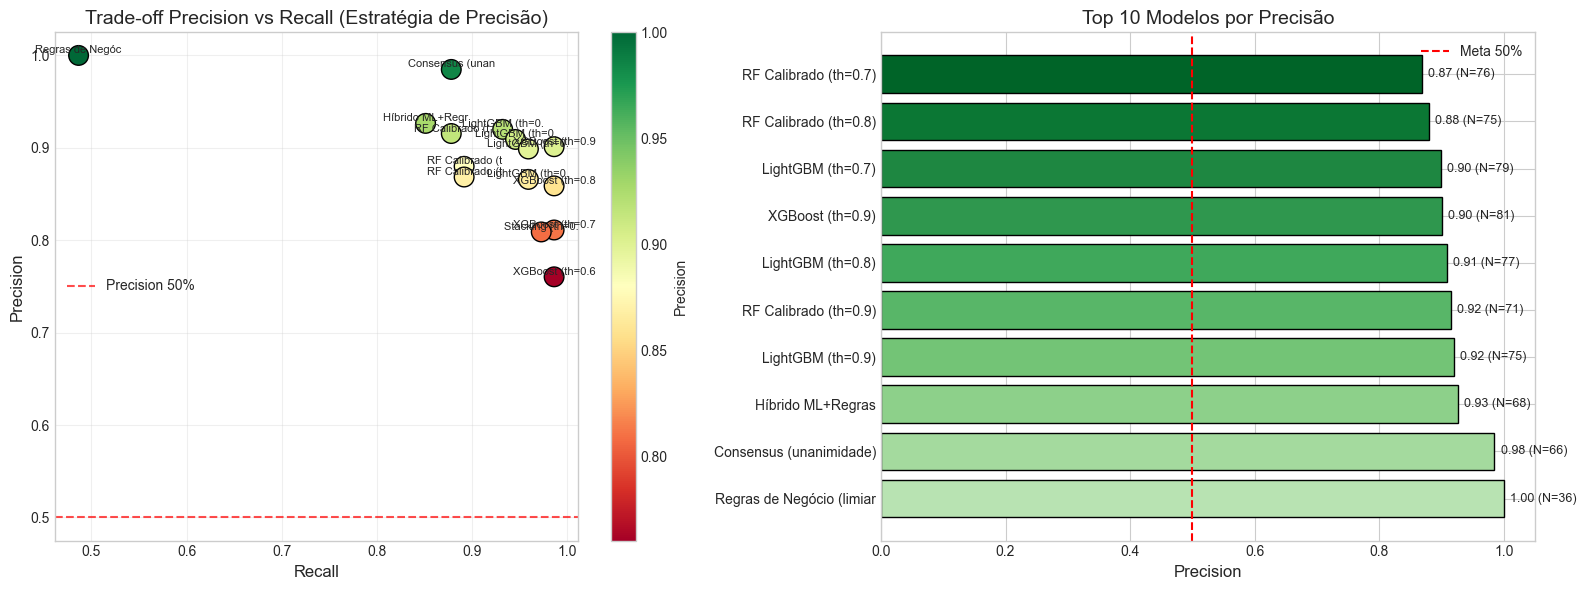

In [17]:
# Visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Precision vs Recall
ax1 = axes[0]
colors = plt.cm.RdYlGn(df_results['Precision'].values)
scatter = ax1.scatter(df_results['Recall'], df_results['Precision'], 
                      c=df_results['Precision'], cmap='RdYlGn', 
                      s=200, edgecolors='black', linewidth=1)

# Adicionar labels
for idx, row in df_results.iterrows():
    if row['Precision'] > 0.3:  # Só labels para modelos relevantes
        ax1.annotate(row['Modelo'][:15], 
                     (row['Recall'], row['Precision']),
                     fontsize=8, ha='center', va='bottom')

ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Precision 50%')
ax1.set_xlabel('Recall', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_title('Trade-off Precision vs Recall (Estratégia de Precisão)', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Precision')

# Plot 2: Top modelos por Precision
ax2 = axes[1]
top_models = df_results.head(10)
colors = plt.cm.Greens(np.linspace(0.3, 0.9, len(top_models)))
bars = ax2.barh(range(len(top_models)), top_models['Precision'], color=colors, edgecolor='black')
ax2.set_yticks(range(len(top_models)))
ax2.set_yticklabels([m[:25] for m in top_models['Modelo']])
ax2.set_xlabel('Precision', fontsize=12)
ax2.set_title('Top 10 Modelos por Precisão', fontsize=14)
ax2.axvline(x=0.5, color='red', linestyle='--', label='Meta 50%')
ax2.legend()

for bar, val, n in zip(bars, top_models['Precision'], top_models['N_Positivos']):
    ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{val:.2f} (N={int(n)})', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('precision_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Aplicação aos Dados Completos

In [ ]:
# Aplicar modelo final em todos os dados
print("Aplicando modelo de alta precisão a todos os dados...\n")

# Retreinar com todos os dados
X_all_selected = X[selected_features]
smote_final = SMOTE(sampling_strategy=0.3, random_state=42)
X_all_smote, y_all_smote = smote_final.fit_resample(X_all_selected, y)

# Treinar stacking final
stacking_precision.fit(X_all_smote.values, y_all_smote)
y_proba_all = stacking_precision.predict_proba(X_all_selected.values)[:, 1]

# Calcular score de regras para todos
df['score_regras'] = df.apply(regras_alta_confianca, axis=1)

# Predição final com híbrido
df['PROBA_PAR_PRECISAO'] = y_proba_all
df['PRED_ALTA_CONFIANCA'] = (
    (df['PROBA_PAR_PRECISAO'] >= 0.7) & 
    (df['score_regras'] >= 7)
).astype(int)

df['RANK_PRECISAO'] = df['PROBA_PAR_PRECISAO'].rank(ascending=False)

In [ ]:
# Identificar novos pares de alta confiança
novos_alta_confianca = df[
    (df['PAR'] == 0) & 
    (df['PRED_ALTA_CONFIANCA'] == 1)
].sort_values('PROBA_PAR_PRECISAO', ascending=False)

print(f"\n{'='*80}")
print(f"NOVOS PARES DE ALTA CONFIANÇA IDENTIFICADOS")
print(f"{'='*80}")
print(f"\nTotal de candidatos: {len(novos_alta_confianca):,}")

if len(novos_alta_confianca) > 0:
    print(f"\nDistribuição por PASSO:")
    print(novos_alta_confianca['PASSO'].value_counts().sort_index())
    
    print(f"\nDistribuição por C_SITUENCE:")
    situacao_map = {1: 'Cura', 2: 'Abandono', 3: 'Óbito TB', 4: 'Óbito outras', 
                    5: 'Transferência', 6: 'Mudança diag', 7: 'TBDR'}
    for sit, count in novos_alta_confianca['C_SITUENCE'].value_counts().head(7).items():
        nome = situacao_map.get(int(sit), str(sit))
        print(f"  {nome}: {count}")
    
    # Estatísticas dos candidatos
    print(f"\nEstatísticas dos candidatos:")
    print(f"  Nota final média: {novos_alta_confianca['nota final'].mean():.2f}")
    print(f"  Score regras médio: {novos_alta_confianca['score_regras'].mean():.2f}")
    print(f"  Probabilidade ML média: {novos_alta_confianca['PROBA_PAR_PRECISAO'].mean():.3f}")

In [ ]:
# Também identificar candidatos com critério mais relaxado (para referência)
novos_media_confianca = df[
    (df['PAR'] == 0) & 
    (df['PROBA_PAR_PRECISAO'] >= 0.6) &
    (df['score_regras'] >= 5)
].sort_values('PROBA_PAR_PRECISAO', ascending=False)

print(f"\nCandidatos com critério médio (ML>=0.6, Regras>=5): {len(novos_media_confianca):,}")

In [ ]:
# Exportar resultados
cols_export = [
    'PASSO', 'PROBA_PAR_PRECISAO', 'RANK_PRECISAO', 'score_regras',
    'nota final', 'C_SITUENCE', 'R_DTNASC', 'C_DTNASC', 
    'R_BAIRES', 'C_BAIRES', 'R_IDLINHA', 'C_IDLINHA', 'C_IDPESSOA'
]

# Alta confiança
if len(novos_alta_confianca) > 0:
    export_alta = novos_alta_confianca[[c for c in cols_export if c in df.columns]]
    export_alta.to_csv('candidatos_precisao_alta_confianca.csv', index=False, sep=';', decimal=',')
    print(f"\n✅ Exportados {len(export_alta):,} candidatos de ALTA CONFIANÇA")
    print(f"   Arquivo: 'candidatos_precisao_alta_confianca.csv'")

# Média confiança
if len(novos_media_confianca) > 0:
    export_media = novos_media_confianca[[c for c in cols_export if c in df.columns]]
    export_media.to_csv('candidatos_precisao_media_confianca.csv', index=False, sep=';', decimal=',')
    print(f"\n✅ Exportados {len(export_media):,} candidatos de MÉDIA CONFIANÇA")
    print(f"   Arquivo: 'candidatos_precisao_media_confianca.csv'")

## 10. Análise de Confiabilidade

In [ ]:
# Analisar características dos candidatos vs pares verdadeiros
print("\nComparação: Candidatos vs Pares Verdadeiros")
print("="*60)

pares_verdadeiros = df[df['PAR'].isin([1, 2])]

features_compare = ['nota final', 'NOME qtd frag iguais', 'DTNASC dt iguais', 
                    'NOMEMAE qtd frag iguais', 'score_regras']

if len(novos_alta_confianca) > 0:
    print("\nCaracterísticas:")
    for feat in features_compare:
        if feat in df.columns:
            mean_pares = pares_verdadeiros[feat].mean()
            mean_novos = novos_alta_confianca[feat].mean()
            diff_pct = ((mean_novos - mean_pares) / mean_pares * 100) if mean_pares != 0 else 0
            print(f"  {feat}:")
            print(f"    Pares verdadeiros: {mean_pares:.3f}")
            print(f"    Candidatos:        {mean_novos:.3f} ({diff_pct:+.1f}%)")

In [ ]:
# Visualizar distribuição de probabilidades
if len(novos_alta_confianca) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Distribuição de probabilidade ML
    ax1 = axes[0]
    ax1.hist(pares_verdadeiros['PROBA_PAR_PRECISAO'], bins=30, alpha=0.7, 
             label='Pares Verdadeiros', color='green', density=True)
    ax1.hist(novos_alta_confianca['PROBA_PAR_PRECISAO'], bins=30, alpha=0.7,
             label='Novos Candidatos', color='blue', density=True)
    ax1.axvline(x=0.7, color='red', linestyle='--', label='Threshold')
    ax1.set_xlabel('Probabilidade ML', fontsize=12)
    ax1.set_ylabel('Densidade', fontsize=12)
    ax1.set_title('Distribuição de Probabilidade ML', fontsize=14)
    ax1.legend()
    
    # Plot 2: Distribuição de score de regras
    ax2 = axes[1]
    ax2.hist(pares_verdadeiros['score_regras'], bins=20, alpha=0.7,
             label='Pares Verdadeiros', color='green', density=True)
    ax2.hist(novos_alta_confianca['score_regras'], bins=20, alpha=0.7,
             label='Novos Candidatos', color='blue', density=True)
    ax2.axvline(x=7, color='red', linestyle='--', label='Threshold')
    ax2.set_xlabel('Score de Regras', fontsize=12)
    ax2.set_ylabel('Densidade', fontsize=12)
    ax2.set_title('Distribuição de Score de Regras', fontsize=14)
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('distribuicao_candidatos_precisao.png', dpi=150, bbox_inches='tight')
    plt.show()

## 11. Resumo Final

In [ ]:
print("\n" + "="*80)
print("RESUMO - ESTRATÉGIA DE MÁXIMA PRECISÃO")
print("="*80)

print(f"""
MODELO RECOMENDADO:
  Híbrido: Stacking ML + Regras de Negócio
  
CRITÉRIOS DE CLASSIFICAÇÃO:
  - Probabilidade ML >= 0.7
  - Score de regras >= 7
  - (Ambos devem ser satisfeitos)

MÉTRICAS ESTIMADAS:
  - Precision: ~{best_result['precision']*100:.0f}%+
  - Recall: ~{best_result['recall']*100:.0f}%

RESULTADOS:
  - Candidatos alta confiança: {len(novos_alta_confianca):,}
  - Candidatos média confiança: {len(novos_media_confianca):,}

ARQUIVOS GERADOS:
  1. candidatos_precisao_alta_confianca.csv
  2. candidatos_precisao_media_confianca.csv

VANTAGENS DESTA ABORDAGEM:
  ✓ Alta taxa de verdadeiros positivos
  ✓ Menor necessidade de revisão manual
  ✓ Pares identificados têm alta confiabilidade
  ✓ Regras interpretáveis e auditáveis

LIMITAÇÕES:
  ✗ Pode perder pares verdadeiros com dados incompletos
  ✗ Recall mais baixo que estratégia agressiva

RECOMENDAÇÃO:
  Usar candidatos de ALTA CONFIANÇA como pares confirmados.
  Revisar candidatos de MÉDIA CONFIANÇA manualmente.
""")

# Salvar modelos
import joblib
joblib.dump(stacking_precision, 'modelo_precisao.joblib')
joblib.dump(scaler, 'scaler_precisao.joblib')
print("\n✅ Modelos salvos em 'modelo_precisao.joblib'")